In [1]:
import Data as data
import model as m

Using TensorFlow backend.


First of all, we need to prepare our data to training.

In [2]:
path_list_train=data.getImagesPath('data')
path_list_test=data.getImagesPath('data1')
X_train,Y_train=data.PreprocessData(path_list_train)
X_test,sizes_test=data.PreprocessData(path_list_test,False)

To faster loading data for trening we will save our arrays to file.

In [3]:
data.savePreparedData(X_test,X_train,Y_train,sizes_test)

To restore this data just call:

X_test,X_train,Y_train,sizes_test=loadPreparedData()

Now let's prepare the model. As the output we can see summary of the model.

In [4]:
model = m.get_unet(128,128,3)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 32) 9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 64, 64, 32)   0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

Our model is ready to train. It will take a while.

In [5]:
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=8, epochs=1)

Train on 603 samples, validate on 67 samples
Epoch 1/1
603/603 [==============================] - 275s 456ms/step - loss: 0.5956 - mean_iou: 0.4864 - val_loss: 0.3194 - val_mean_iou: 0.5592


We are ready to make some prediction. 

In [6]:
preds_test = model.predict(X_test, verbose=1)

65/65 [==============================] - 7s 102ms/step


In [7]:
print(preds_test[0])

[[[0.42295977]
  [0.43871608]
  [0.4376704 ]
  ...
  [0.4386902 ]
  [0.44969833]
  [0.45365235]]

 [[0.42485115]
  [0.4710574 ]
  [0.46714002]
  ...
  [0.42890728]
  [0.4488186 ]
  [0.45289323]]

 [[0.4333932 ]
  [0.4707563 ]
  [0.4494464 ]
  ...
  [0.42464826]
  [0.4508798 ]
  [0.45066467]]

 ...

 [[0.43796882]
  [0.4320224 ]
  [0.40792218]
  ...
  [0.40513933]
  [0.4290266 ]
  [0.4425232 ]]

 [[0.4426146 ]
  [0.43605122]
  [0.42467517]
  ...
  [0.42920968]
  [0.44036222]
  [0.44348103]]

 [[0.43697578]
  [0.4424854 ]
  [0.4394005 ]
  ...
  [0.43484303]
  [0.439839  ]
  [0.45662495]]]


As we can see, we get the probability of nuclei detection on particular pixel. Let's filter it.

In [9]:
import numpy as np
preds_test_t = (preds_test > 0.5).astype(np.uint8)

We have to resize out images to thiers original sizes, to get proper prediction.

In [10]:
preds_test_upsampled =data.resizeTest(path_list_test,preds_test,sizes_test)

The last thing we need to do is code our output as RLE and save the output to csv file.

In [12]:
import os
new_test_ids = []
rles = []
for n, path in enumerate(path_list_test):
    rle = list(data.prob_to_rles(preds_test_upsampled[n]))
    rles.extend(rle)
    new_test_ids.extend([os.path.splitext(os.path.basename(os.path.normpath(str(path))))[0]] * len(rle))

data.saveOutputTocsv(new_test_ids,rles)

We have our output in file out.csv. Let's plot our prediction!

/home/kamil/.local/lib/python3.5/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
/home/kamil/.local/lib/python3.5/site-packages/skimage/io/_plugins/matplotlib_plugin.py:74: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "
/home/kamil/.local/lib/python3.5/site-packages/matplotlib/axes/_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


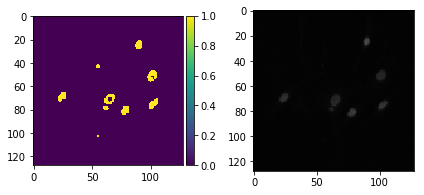

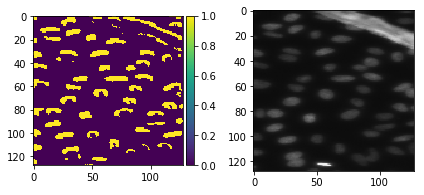

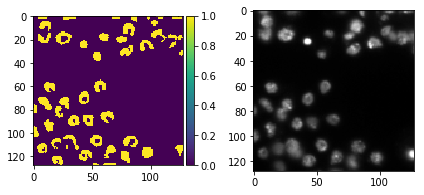

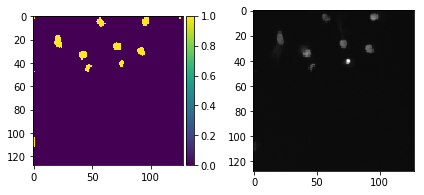

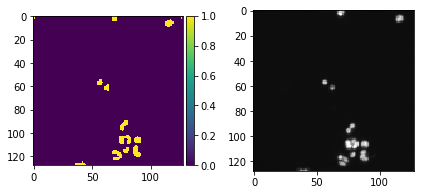

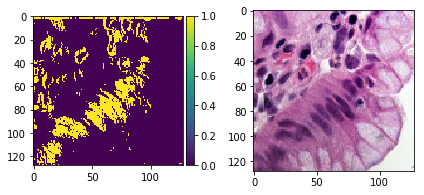

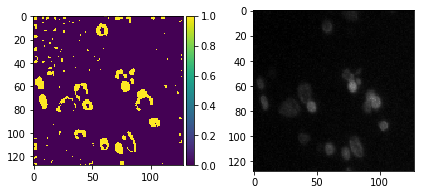

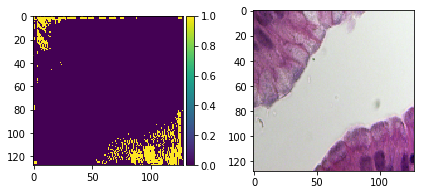

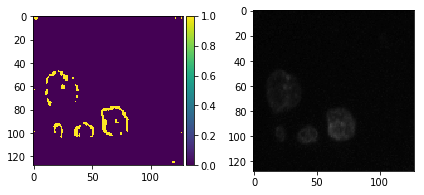

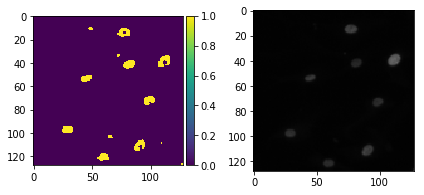

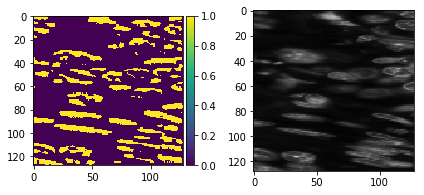

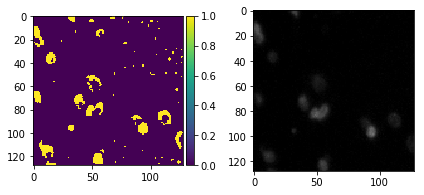

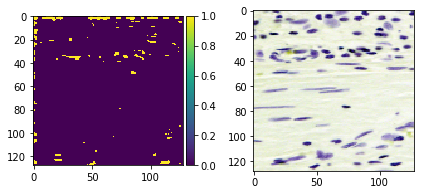

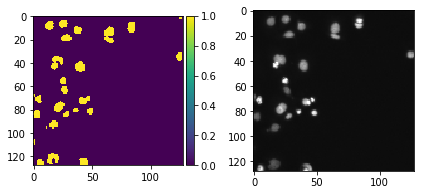

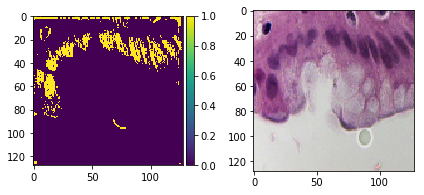

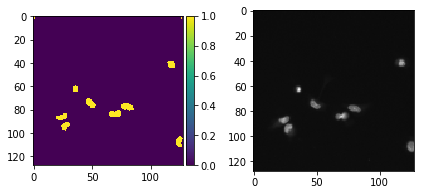

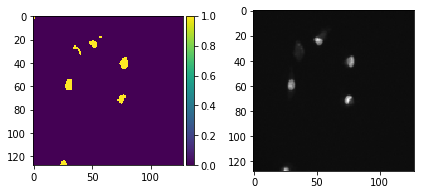

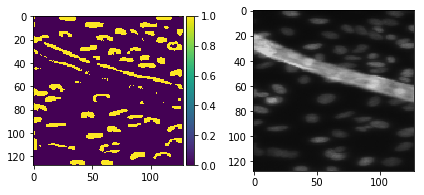

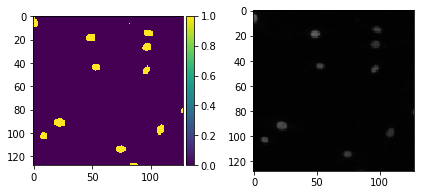

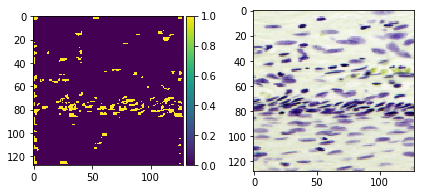

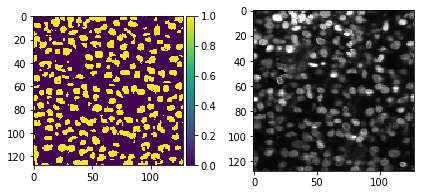

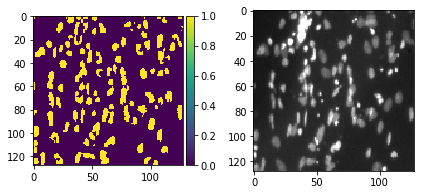

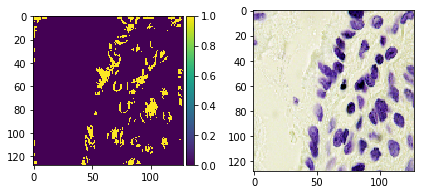

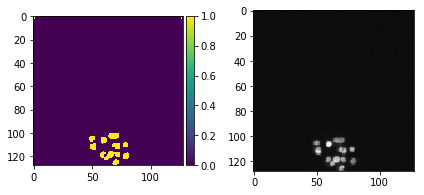

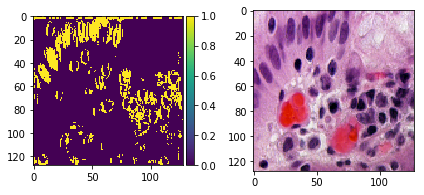

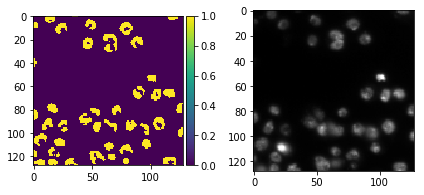

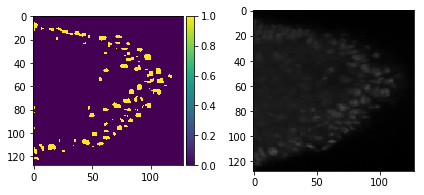

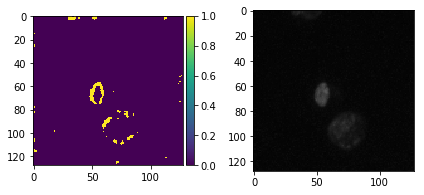

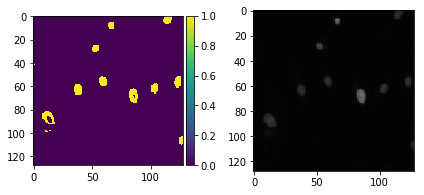

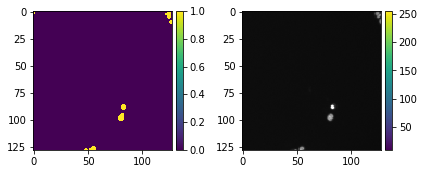

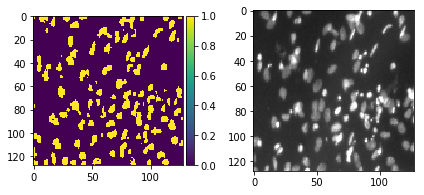

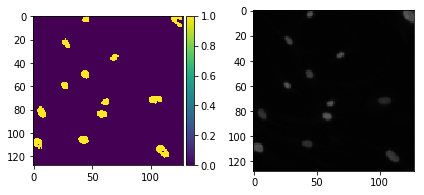

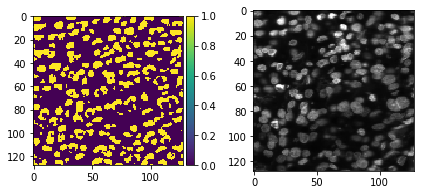

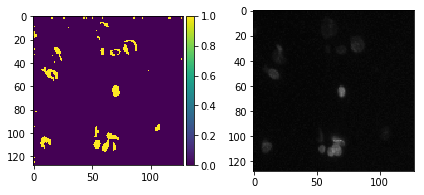

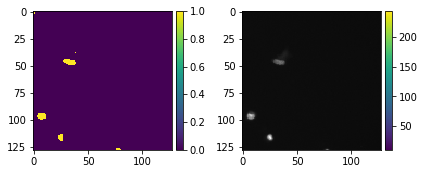

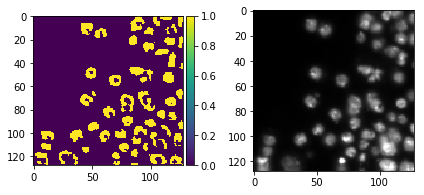

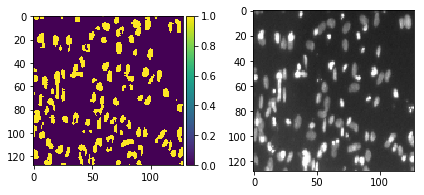

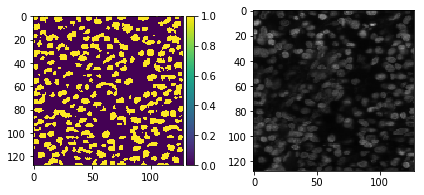

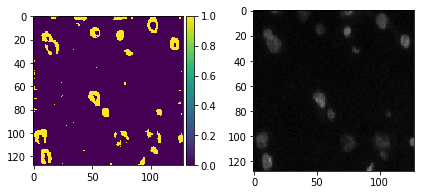

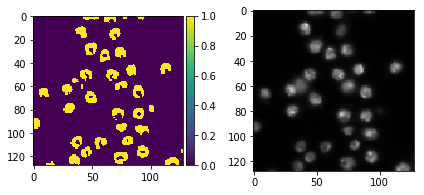

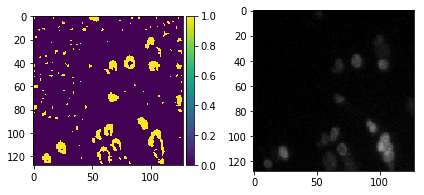

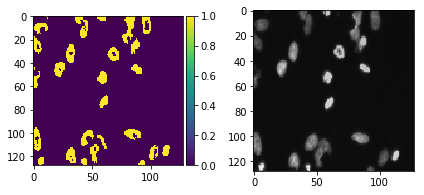

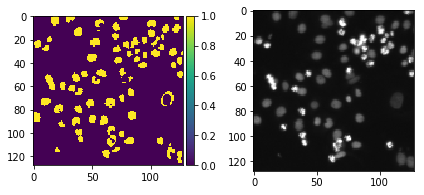

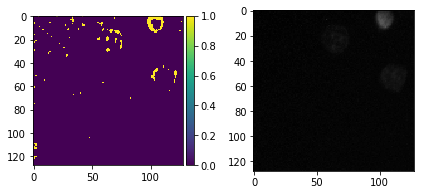

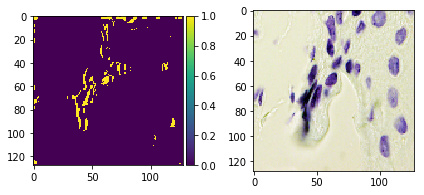

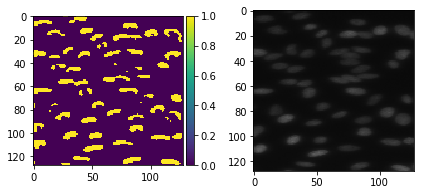

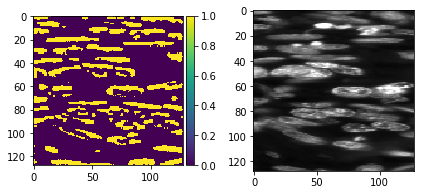

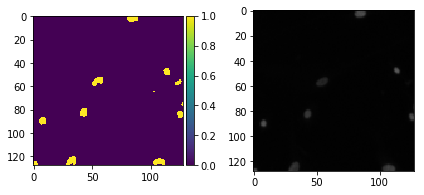

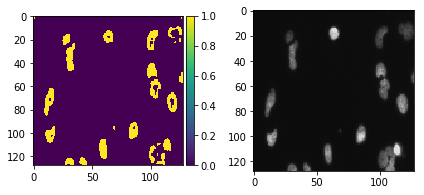

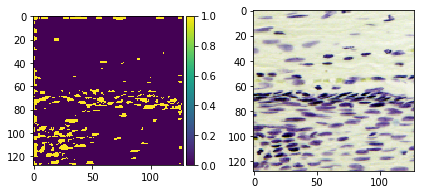

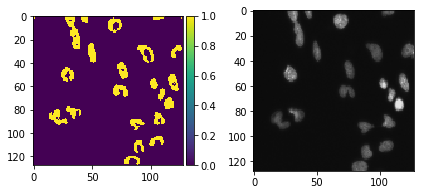

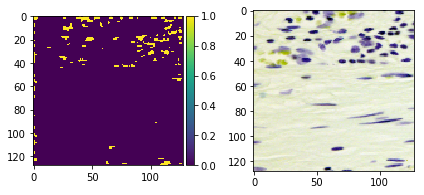

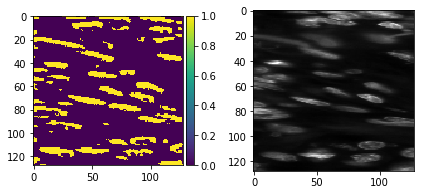

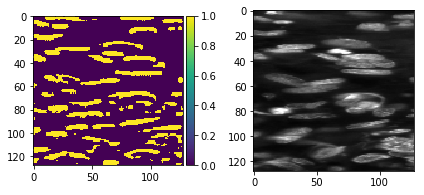

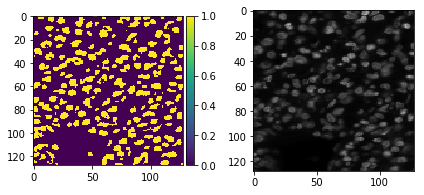

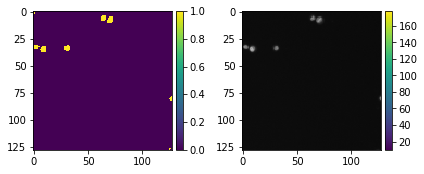

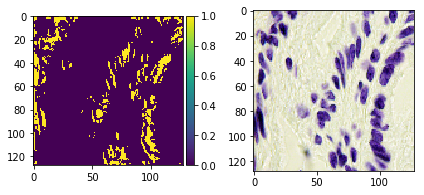

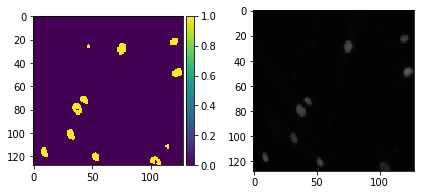

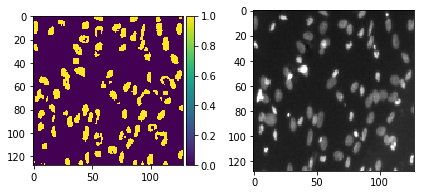

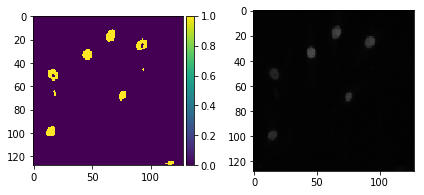

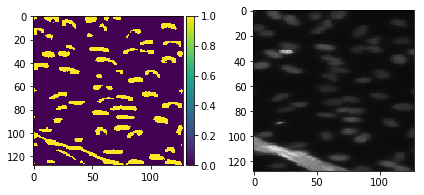

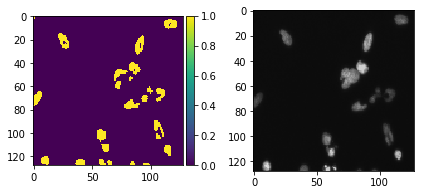

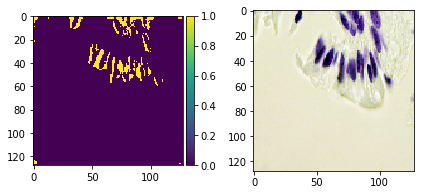

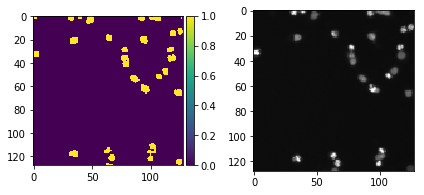

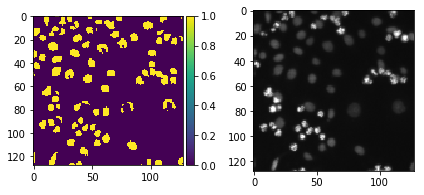

In [13]:
import matplotlib.pyplot as plt
from skimage.io import imread,imshow
for i in range(len(preds_test_t)):
        plt.subplot(1,2,1)
        imshow(np.squeeze(preds_test_t[i]))
        plt.subplot(1,2,2)
        imshow(X_test[i])
        plt.show()